# Import

In [1]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE  # For handling class imbalance
import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aryan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aryan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aryan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Data

In [2]:
news_dataset = pd.read_csv('data/train.csv')
news_dataset.fillna('', inplace=True)
news_dataset['content'] = news_dataset['author'] + ' ' + news_dataset['title'] + ' ' + news_dataset['text']


print(news_dataset.head())
print(news_dataset.info())

   id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  \
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1   
1  Ever get the feeling your life circles the rou...      0   
2  Why the Truth Might Get You Fired October 29, ...      1   
3  Videos 15 Civilians Killed In Single US Airstr...      1   
4  Print \nAn Iranian woman has been sentenced to...      1   

                                             content  
0  Darrell Lucus House Dem Aide: We Didn’t Even S...  
1  Daniel J. Flynn FLYNN: Hill

# Text Preprocessing

In [3]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(content):
    content = re.sub('[^a-zA-Z]', ' ', content).lower()
    tokens = word_tokenize(content)
    lemmatized = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(lemmatized)

news_dataset['content'] = news_dataset['content'].apply(preprocess_text)

print(news_dataset['content'].head())

0    darrell lucus house dem aide even see comey le...
1    daniel j flynn flynn hillary clinton big woman...
2    consortiumnews com truth might get fired truth...
3    jessica purkiss civilian killed single u airst...
4    howard portnoy iranian woman jailed fictional ...
Name: content, dtype: object


In [4]:
X = news_dataset['content']
y = news_dataset['label']

y = y.values

# Text to Number

In [5]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))  # Include unigrams and bigrams

X = vectorizer.fit_transform(X)

print(f"Feature matrix shape: {X.shape}")

Feature matrix shape: (20800, 5000)


# Class imbalance

In [6]:
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

print("Class distribution after SMOTE:", np.bincount(y))

Class distribution after SMOTE: [10413 10413]


# Test Train

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)

print(f"Training set size: {X_train.shape}, Testing set size: {X_test.shape}")

Training set size: (16660, 5000), Testing set size: (4166, 5000)


# Logistic Regression

In [8]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'lbfgs'],  # Optimization algorithm
    'max_iter': [100, 200, 500]  # Maximum number of iterations
}

log_reg = LogisticRegression()

grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

best_log_model = grid_search.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'C': 10, 'max_iter': 100, 'solver': 'liblinear'}
Best Cross-Validation Accuracy: 0.9686074429771908


# Random Forest

In [9]:
rf_model = RandomForestClassifier(random_state=42)

rf_model.fit(X_train, y_train)

y_test_pred_rf = rf_model.predict(X_test)
rf_test_accuracy = accuracy_score(y_test, y_test_pred_rf)

print(f"Random Forest Test Accuracy: {rf_test_accuracy:.4f}")

Random Forest Test Accuracy: 0.9686


# XG Boost

In [11]:
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)

xgb_model.fit(X_train, y_train)

y_test_pred_xgb = xgb_model.predict(X_test)
xgb_test_accuracy = accuracy_score(y_test, y_test_pred_xgb)

print(f"XGBoost Test Accuracy: {xgb_test_accuracy:.4f}")

XGBoost Test Accuracy: 0.9825


# SVM

In [12]:
svm_model = SVC(kernel='linear', random_state=42)

svm_model.fit(X_train, y_train)

y_test_pred_svm = svm_model.predict(X_test)
svm_test_accuracy = accuracy_score(y_test, y_test_pred_svm)

print(f"SVM Test Accuracy: {svm_test_accuracy:.4f}")

SVM Test Accuracy: 0.9676


# Predictions and accuracy

In [13]:
model_accuracies = {
    'Logistic Regression': grid_search.best_score_,  # Use cross-validation score for fairness
    'Random Forest': rf_test_accuracy,
    'XGBoost': xgb_test_accuracy,
    'SVM': svm_test_accuracy
}

print("\nModel Comparison:")
for model, accuracy in model_accuracies.items():
    print(f"{model}: Test Accuracy = {accuracy:.4f}")


Model Comparison:
Logistic Regression: Test Accuracy = 0.9686
Random Forest: Test Accuracy = 0.9686
XGBoost: Test Accuracy = 0.9825
SVM: Test Accuracy = 0.9676


In [14]:
print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, best_log_model.predict(X_test)))

print("\nClassification Report (Random Forest):")
print(classification_report(y_test, y_test_pred_rf))

print("\nClassification Report (XGBoost):")
print(classification_report(y_test, y_test_pred_xgb))

print("\nClassification Report (SVM):")
print(classification_report(y_test, y_test_pred_svm))


Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2083
           1       0.97      0.97      0.97      2083

    accuracy                           0.97      4166
   macro avg       0.97      0.97      0.97      4166
weighted avg       0.97      0.97      0.97      4166


Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2083
           1       0.97      0.97      0.97      2083

    accuracy                           0.97      4166
   macro avg       0.97      0.97      0.97      4166
weighted avg       0.97      0.97      0.97      4166


Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2083
           1       0.98      0.99      0.98      2083

    accuracy                           0.98      4166
   macro

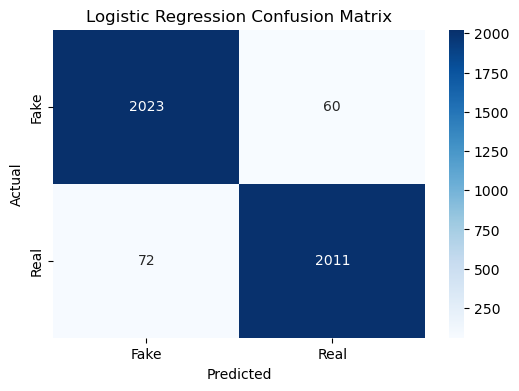

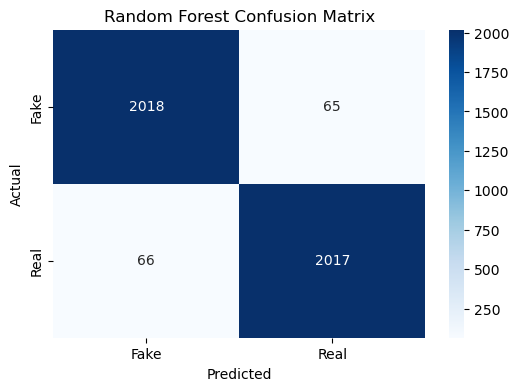

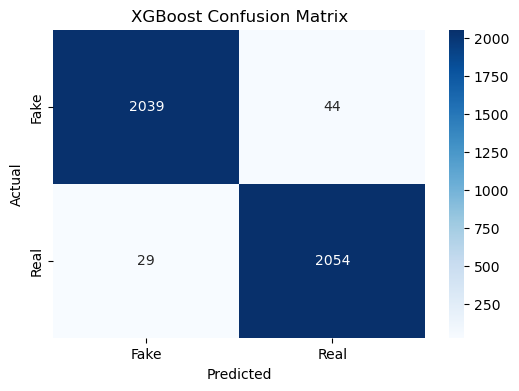

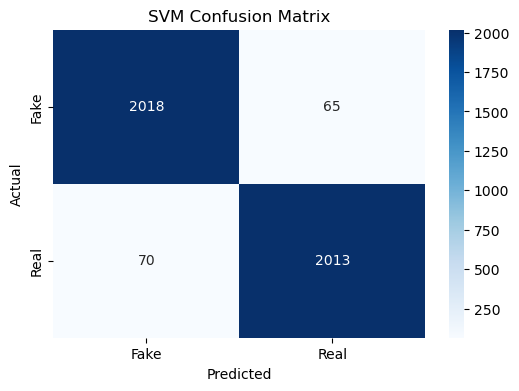

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_confusion_matrix(y_test, best_log_model.predict(X_test), "Logistic Regression Confusion Matrix")
plot_confusion_matrix(y_test, y_test_pred_rf, "Random Forest Confusion Matrix")
plot_confusion_matrix(y_test, y_test_pred_xgb, "XGBoost Confusion Matrix")
plot_confusion_matrix(y_test, y_test_pred_svm, "SVM Confusion Matrix")


# Save Model

In [16]:
import pickle

with open('best_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)

print("Best model saved successfully!")

Best model saved successfully!


In [18]:
with open('vectorizer.pkl', 'wb') as vec_file:
    pickle.dump(vectorizer, vec_file)